# 沿海水域关键营养物质的时空分布估算

## 1 项目介绍

###  1.1 背景介绍

**近海DSi精细尺度反演的时空智能方法**

该案例显示了一种时空加权智能方法，可以获得沿海溶解硅酸盐（DSi）的高分辨率和长期分布。在近岸海域观察并揭示了由生物和物理因素驱动的精细尺度DSi变化和影响。

溶解硅酸盐（DSi）从陆地向海岸环境的迁移是全球生物地球化学循环的重要组成部分。由于沿海水域强烈的陆海相互作用，沿海DSi的空间分布呈现出不规则特征（受陆地输入和海洋地形的影响），时间变化迅速，周期性波动短暂（受生物效应和洋流的影响）。然而，由于时空建模的不成熟和数据采样的低分辨率，目前对沿海DSi的研究通常以数百公里的空间和季节时间分辨率描述其粗略变化。因此，该项目将结合先进的时空分析模型和高分辨率数据集，以更高的时空分辨率分析海上DSi分布的变化。

> [Qi, J., Du, Z., Wu, S., Chen, Y., & Wang, Y. (2023). A spatiotemporally weighted intelligent method for exploring fine-scale distributions of surface dissolved silicate in coastal seas. Science of The Total Environment , 886, 163981.  ](https://doi.org/10.1016/j.scitotenv.2023.163981)  

### 1.2 数据说明

2010年至2018年浙江近海地表DSi数据集（通过将MODIS遥感数据集与近海地表溶解硅酸盐现场数据集进行匹配获得）。

### 1.3 分析过程

- 依赖库安装
- 数据集导入
- 模型设置
- 模型训练

### 1.4 研究区域示意图


![Image Name](https://mydde.deep-time.org/s3/static-files/upload/upload/1695121607986_1.jpg)  

## 2 准备工作

依赖库导入

In [1]:
from gnnwr.models import GTNNWR
from gnnwr.datasets import init_dataset
import numpy as np
import pandas as pd

## 3 模型训练

### 3.1 数据导入

In [2]:
data = pd.read_csv('../data/demo_data_gtnnwr.csv')
data.head()

,refl_b01,refl_b02,refl_b03,refl_b04,refl_b05,refl_b07,proj_x,proj_y,day,SiO3
0,1895,1251,1737,1872,543,280,736685.4179,3314205.295,113,1.049
1,1621,1066,1435,1665,757,511,736685.4179,3314205.295,121,1.209
2,1587,1141,1807,1864,1211,1024,736685.4179,3314205.295,152,1.102
3,1121,1012,1411,1324,711,485,768193.4945,3402138.581,168,0.945
4,913,203,840,1035,114,63,736685.4179,3314205.295,200,1.350


通过`init_dataset()`函数，用户可以设置输入数据、测试集大小、验证集大小、自变量、因变量、空间属性、时间属性、编号列、随机种子和批量大小。

初始化的数据集可以使用`save()`方法保存，`read`方法可以用于`read`保存的结果。

In [3]:
data["id"] = np.arange(len(data))
train_dataset, val_dataset, test_dataset = init_dataset(data=data,
                                                        test_ratio=0.15,
                                                        valid_ratio=0.1,
                                                        x_column=['refl_b01', 'refl_b02',
                                                                  'refl_b03', 'refl_b04', 'refl_b05',
                                                                  'refl_b07'],
                                                        y_column=['SiO3'],
                                                        spatial_column=[
                                                            'proj_x', 'proj_y'],
                                                        temp_column=['day'],
                                                        id_column=['id'],
                                                        use_model="gtnnwr",
                                                        sample_seed=48,
                                                        batch_size=1024)

### 3.2 模型设置

该模型接受训练集、验证集、测试集、隐藏层和优化器等参数，并可以设置网络结构、优化器类型和学习率调整方法。

`add_graph()`函数可用于保存模型的图结构，可以在Tensorboard中查看。

In [4]:
optimizer_params = {
    "scheduler": "MultiStepLR",
    "scheduler_milestones": [1000, 2000, 3000, 4000],
    "scheduler_gamma": 0.8,
}
gtnnwr = GTNNWR(train_dataset, val_dataset, test_dataset, [[3], [512, 256, 64]], drop_out=0.4, optimizer='Adadelta', optimizer_params=optimizer_params,
                write_path="../demo_result/gtnnwr/runs/",  # 这里需要修改
                model_save_path="../demo_result/gtnnwr/models/",
                log_path="../demo_result/gtnnwr/logs/",
                model_name="GTNNWR_DSi")
gtnnwr.add_graph()

Add Graph Successfully


### 3.3 模型训练  

使用`run`方法可以进行模型训练，并可以设置训练步长和早停步长。

In [5]:
gtnnwr.run(200, 50)

 37%|███▋      | 74/200 [01:37<02:45,  1.31s/it, Train Loss=3.074955, Train R2=-4.340324, Train AIC=tensor(8791.8643, device='cuda:0', grad_fn=<AddBackward0>), Valid Loss=5.85, Valid R2=-9.97, Best Valid R2=-0.733, Learning Rate=0.1]   


Training stop! Model has not been improved for over 50 epochs.


### 3.4 模型输出

使用`result()`可以获得最优模型的基本信息以及模型在测试集上的运行结果

使用`reg_result()`可以保存整个数据集上最优模型的运行结果，包括模型计算的时空非平稳权重。

In [6]:
gtnnwr.result()


--------------------Result Information----------------
Test Loss: |                   0.89179
Test R2  : |                  -0.62975
Train R2 : |                  -0.58605
Valid R2 : |                  -0.73272
RMSE: |                        0.94434
MAE:  |                        0.71799
AICc: |                     1188.79565


In [7]:
result_data = gtnnwr.reg_result('../demo_result/gtnnwr/gtnnwr_result.csv')
result_data

,coef_refl_b01,coef_refl_b02,coef_refl_b03,coef_refl_b04,coef_refl_b05,coef_refl_b07,bias,Pred_SiO3,id,dataset_belong,denormalized_pred_result
0,-4.235820,-2.341071,0.668600,0.398847,4.178210,4.179814,1.502112,1.927536,1870,train,1.927536
1,-4.235820,-2.341071,0.668600,0.398847,4.178210,4.179814,1.502112,1.207748,525,train,1.207748
2,-4.235820,-2.341071,0.668600,0.398847,4.178210,4.179814,1.502112,1.141924,2712,train,1.141924
3,-4.235820,-2.341071,0.668600,0.398847,4.178210,4.179814,1.502112,0.906820,1766,train,0.906820
4,-4.235820,-2.341071,0.668600,0.398847,4.178210,4.179814,1.502112,1.094459,2070,train,1.094459
...,...,...,...,...,...,...,...,...,...,...,...
2896,-4.235821,-2.341071,0.668601,0.398846,4.178208,4.179814,1.502112,1.787942,63,test,1.787942
2897,-4.235821,-2.341071,0.668601,0.398846,4.178208,4.179814,1.502112,1.133581,2173,test,1.133581
2898,-4.235821,-2.341071,0.668601,0.398846,4.178208,4.179814,1.502112,1.265083,1839,test,1.265083
2899,-4.235821,-2.341071,0.668601,0.398846,4.178208,4.179814,1.502112,0.925056,1253,test,0.925056


### 3.5 模型结果分析


模型的输出结果可以通过绘制图像和其他方法导入和分析

R2: -0.603229993909215


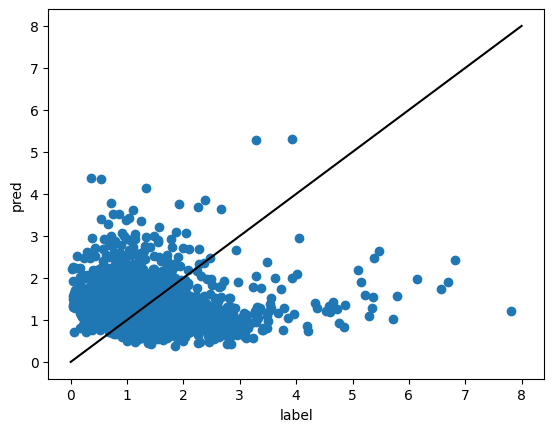

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score as r2
result_data.sort_values(by='id', inplace=True)
data.sort_values(by='id', inplace=True)
print('R2:', r2(data['SiO3'], result_data['Pred_SiO3']))
plt.scatter(data['SiO3'], result_data['Pred_SiO3'])
plt.plot([i for i in range(9)], [i for i in range(9)], color='black')
plt.xlabel('label')
plt.ylabel('pred')
plt.show()

In [9]:
ana_data = pd.merge(data, result_data, on='id')

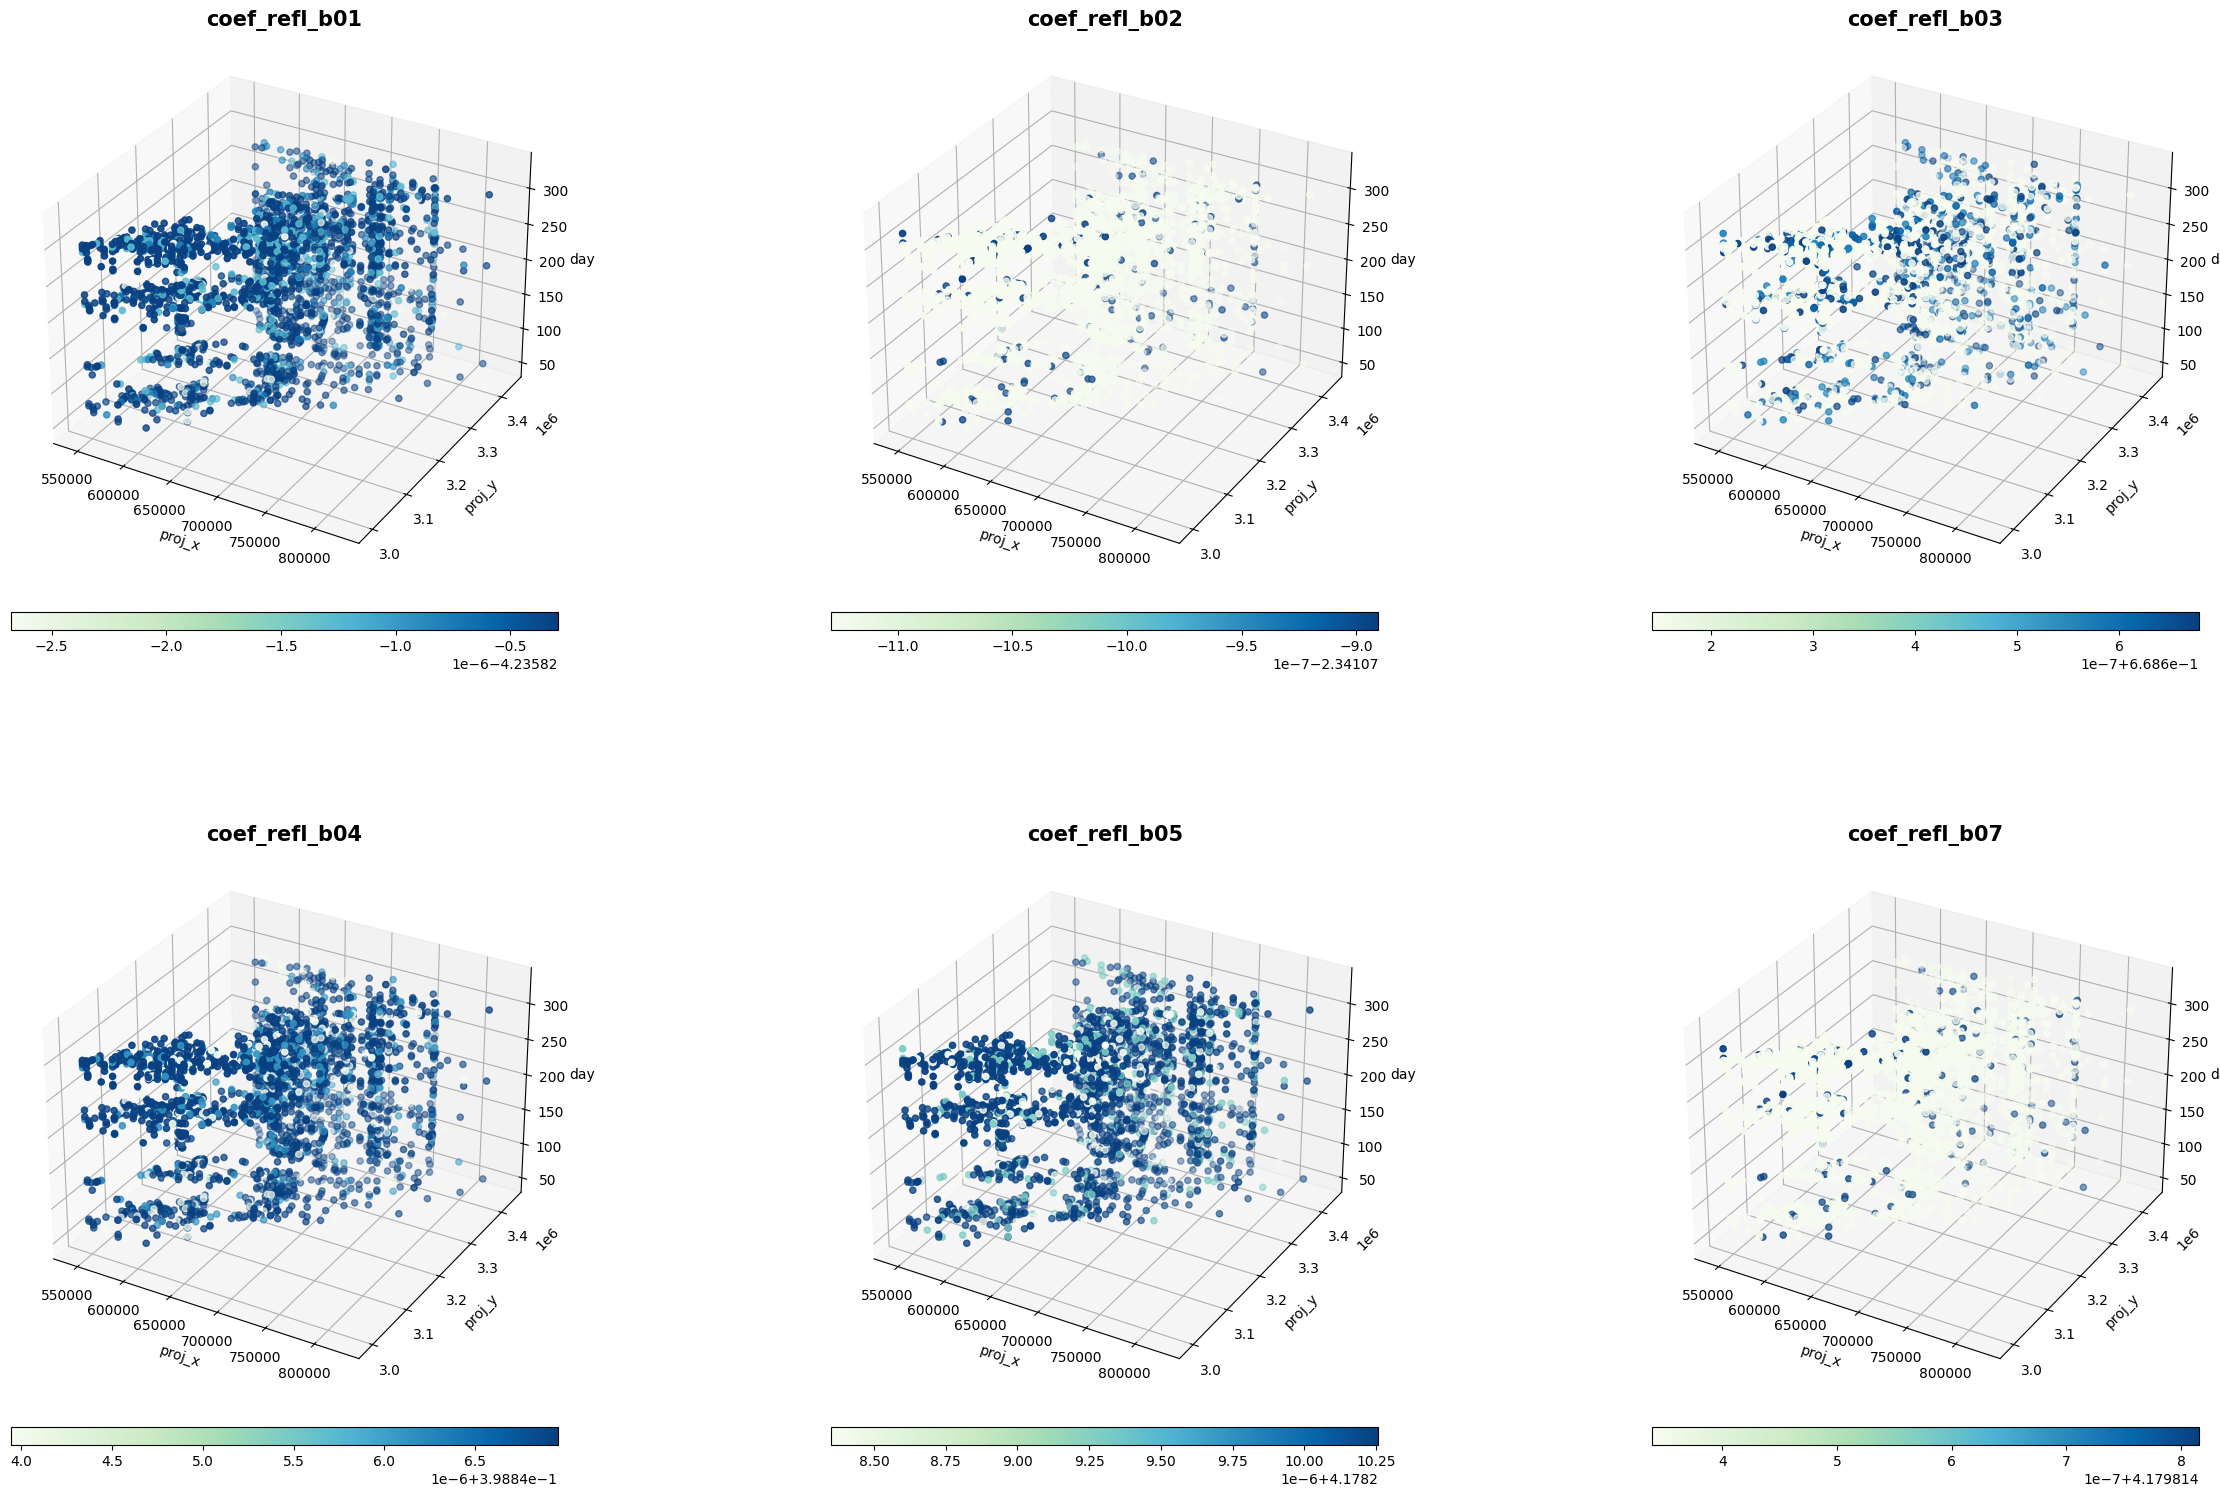

In [10]:
fig = plt.figure(figsize=(30, 30))
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
id = 1
for i in [1, 2, 3, 4, 5, 7]:
    ax = fig.add_subplot(3, 3, id, projection='3d')
    fig.colorbar(ax.scatter(ana_data['proj_x'], ana_data['proj_y'], ana_data['day'],
                            c=ana_data['coef_refl_b0'+str(i)], cmap='GnBu'),
                 shrink=0.8, aspect=30, orientation='horizontal', pad=0.05)
    ax.set_xlabel('proj_x')
    ax.set_ylabel('proj_y')
    ax.set_zlabel('day')
    ax.set_title('coef_refl_b0'+str(i), fontsize=15, fontweight='bold')
    id += 1